# My Body Weight Web Application

## Introduction
This part briefly explains the objectives of this project.
I was fat for as long as I could remember before 2014, my body weight was constantly over 230lbs and reached a peak over 250lbs in the year of 2014.  
Thats when I finally decided to lose weight.
I did lots of researches online and tried out so many different stuff myself and finally successfully lost 100 lbs in a year and began my fitness journey ever since.   
I got my personal trainer certificate from American Council on Exercise (ACE) and I am a certifited nutritional specialist from ACE as well. I learned how to be fit and stay fit.   
Thats when I started to monitor my body weight constantly. I lost a year or two of body weight data initially because I was using another app.   
After doing the last project which is just for exploratory purposes, now I believe I can use my newly learned skills to build a web application of my own to do the job where I would do manually automatically for me.
Below is a picture of my personal body transformation of before and after. Check it out!!

<img src="https://raw.githubusercontent.com/DericMei/Body-Weight-Project/main/Pictures/IMG_0260.JPG" width="800" height="500"/>

## Background Knowledge

One kg of pure fat is equal to 7700 calories. For cutting, which is a fancy way for bodybuilders to say weight loss, normally the best way to track progress is to follow the steps below:
1. Record body weight every morning after waking up after peeing before drinking water (for consistency).
2. Calculate weekly average body weight after a whole week.
3. Compare the weekly average after every week with the data from last week.
4. Calculate the difference and use this kg value to multiply 7700 to know exactly how much caloric deficit one is in.
There is no easy to use app in the market right now that I could find that does this job easily. Every year, after winter, when I am in my normal cutting phase, I will have to manually record my body weight everyday, set a day point for weekly summary, and every week, calculate my weekly average and manually do all the calculations to figure out if I am on the right track of cutting. This is extremely painful for me. Now with the knowledge I have right now, I could build this perfect web application for myself that does the job for me. Hope you can learn something from this if you want to lose some weight!

Example:
Say if my weekly average for last week is 80kg, and 79.5kg for this week, then the difference is 0.5kg, using it to multiply 7700 calories, I get 3350 calories. This means that over the past week, my caloric defict is roughtly around this number, I can further use this number to calculate daily caloric deficit, where I can get roughly 500 calories. This is a good amount. Right now I am trying to stay at around 800 calories daily caloric deficit and I haven't manually calculated yet since I am too lazy. Hope this project can help me find out!!!!

## Import Packages

In [238]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import sqlite3
from sqlite3 import Error
from sqlalchemy import create_engine, text, MetaData, Table, UniqueConstraint
import os
from dotenv import load_dotenv
from datetime import datetime
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
from prophet.plot import plot_cross_validation_metric, add_changepoints_to_plot
from itertools import product
import pickle

## Data Cleaning

In [63]:
# Read in data
filepath = 'bodyweight.csv'
df = pd.read_csv(filepath)
df.head()

,type,sourceName,sourceVersion,productType,device,startDate,endDate,unit,value,HKWasUserEntered,HKExternalUUID
0,HKQuantityTypeIdentifierBodyMass,Health,10.0.2,"iPhone8,2",NaN,2016-09-28 18:24:46 +0000,2016-09-28 18:24:46 +0000,kg,77.110640,NaN,NaN
1,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.1.2,"iPhone10,3",NaN,2017-12-18 06:09:09 +0000,2017-12-18 06:09:09 +0000,kg,80.000000,NaN,NaN
2,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.2.2,"iPhone10,3",NaN,2018-04-26 01:38:50 +0000,2018-04-26 01:38:50 +0000,kg,83.000000,NaN,NaN
3,HKQuantityTypeIdentifierBodyMass,Zijie的 iPhone,11.2.2,"iPhone10,3",NaN,2018-05-07 17:26:47 +0000,2018-05-07 17:26:47 +0000,kg,83.000000,NaN,NaN
4,HKQuantityTypeIdentifierBodyMass,Health,11.3.1,"iPhone10,3",NaN,2018-05-08 23:53:00 +0000,2018-05-08 23:53:00 +0000,kg,82.372374,1.0,NaN


In [64]:
# since I am only interested in the date and weight I am only keeping these 2 rows
df = df[['startDate', 'value']]

# renaming columns
df = df.rename(columns={'startDate': 'date', 'value': 'weight'})

# changing the formate of the date column
df['date'] = pd.to_datetime(df['date'])
df['date'] = df['date'].dt.date
df

,date,weight
0,2016-09-28,77.110640
1,2017-12-18,80.000000
2,2018-04-26,83.000000
3,2018-05-07,83.000000
4,2018-05-08,82.372374
...,...,...
1534,2024-01-20,85.400101
1535,2024-01-21,85.299860
1536,2024-01-22,85.400101
1537,2024-01-23,86.300032


In [65]:
# Creating a function to plot weight over time easily later when cleaning up data

def plot_weight_over_time(df):
    # Make a copy of the dataframe to ensure the original data is not affected
    df_plot = df.copy()

    # Convert the 'date' column to datetime if it's not already
    df_plot['date'] = pd.to_datetime(df_plot['date'])
    
    # Ensure that the 'date' column is the index of the DataFrame for time series plotting
    df_plot.set_index('date', inplace=True)

    # Sort the DataFrame by the index (date) to ensure correct plotting
    df_plot.sort_index(inplace=True)

    # Plotting the data
    plt.figure(figsize=(15, 5))  # Adjust the size as needed
    plt.plot(df_plot.index, df_plot['weight'], marker='o', linestyle='-', color='green')

    # Improving the aesthetics
    plt.title('Weight Over Time')
    plt.xlabel('Date')
    plt.ylabel('Weight (kg)')
    plt.grid(True)
    plt.xticks(rotation=45)  # Rotates the date labels to avoid overlap

    # Handling missing values by breaking the line at missing dates
    plt.gca().set_prop_cycle(None)  # Reset the color cycle to reuse the first color

    # Show only the points where the 'weight' is not missing
    for date, weight in df_plot.dropna().iterrows():
        plt.plot(date, weight, marker='o', linestyle='', color='red')

    # Show the plot
    plt.tight_layout()  # Adjust subplot params so that the subplot(s) fits in to the figure area.
    plt.show()

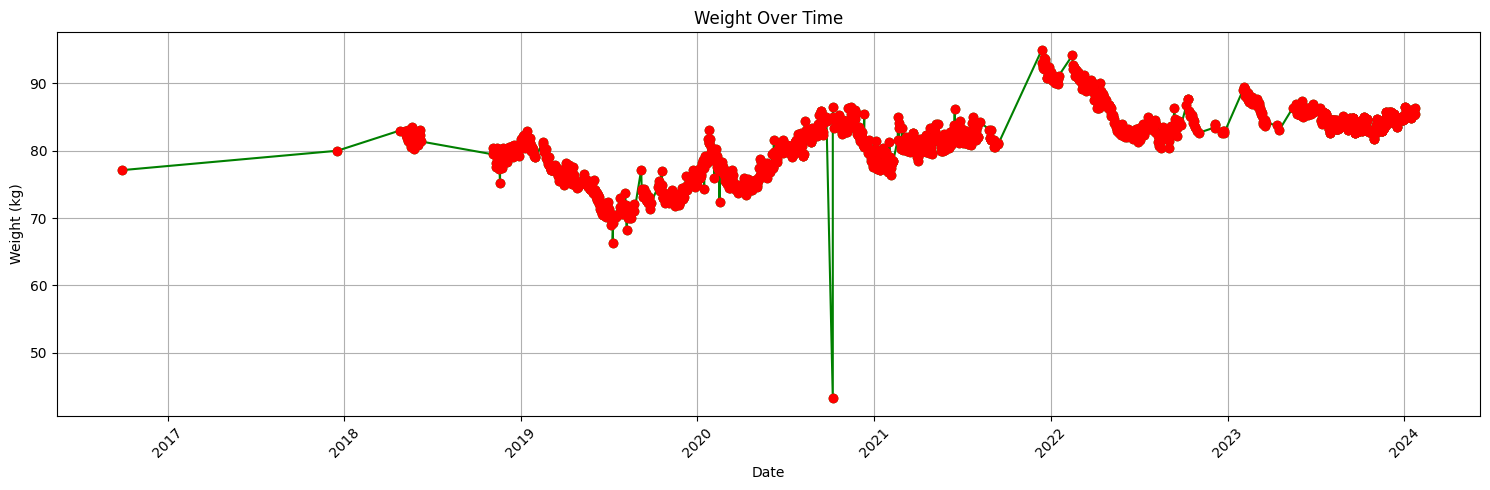

In [66]:
plot_weight_over_time(df)

There are tons of missing values here, shame on me for not recording consistantly T_T.
To handle these data and make my model more consistant, I need to do some processing with these data. 
- First I cannot seem to use any data before spring of 2018 because there is only 2 data points. 
- Second, there is one outlier in later 2020 where I recorded about 40 kg for my date, I think it might just be a typo when I was recording.
- Then because of some missing value in the middle here and there, I need to find a logic to fill up those missing values to make data more consistant.

In [67]:
# Droping first 2 data points
df = df.drop(df.index[0:2])

# Droping the low data point in late 2020
df = df[df['weight'] > 50]

In [68]:
# write a function to fill in all the missing values for weight to make sure there is a weight value for each date.
# Basic logic here is for any missing weight, find the last recorded date and nearest next record and fill in with the linear relationship using the pandas interpolate function.

def fill_missing_values_with_interpolation(df, date_column='date', value_column='weight'):

    df_new = df.copy()

    # Ensure that 'date' is a datetime column
    df_new[date_column] = pd.to_datetime(df_new[date_column])
    
    # Drop duplicates, keeping only the first entry for each date
    df_new = df_new.drop_duplicates(subset=date_column)
    
    # Set 'date' as the DataFrame index
    df_new.set_index(date_column, inplace=True)
    
    # Create a continuous date range from the start date to the end date
    full_date_range = pd.date_range(start=df_new.index.min(), end=df_new.index.max(), freq='D')
    
    # Reindex the DataFrame with the full date range
    df_new = df_new.reindex(full_date_range)
    
    # Interpolate missing 'weight' values using a time-weighted method
    df_new[value_column] = df_new[value_column].interpolate(method='time')
    
    # Reset the index to turn the 'date' back into a column
    df_new.reset_index(inplace=True)
    
    # Rename the index back to 'date'
    df_new.rename(columns={'index': date_column}, inplace=True)
    
    return df_new

In [69]:
# use the function to create a new dataframe that has continuous weight data
df_final = fill_missing_values_with_interpolation(df)

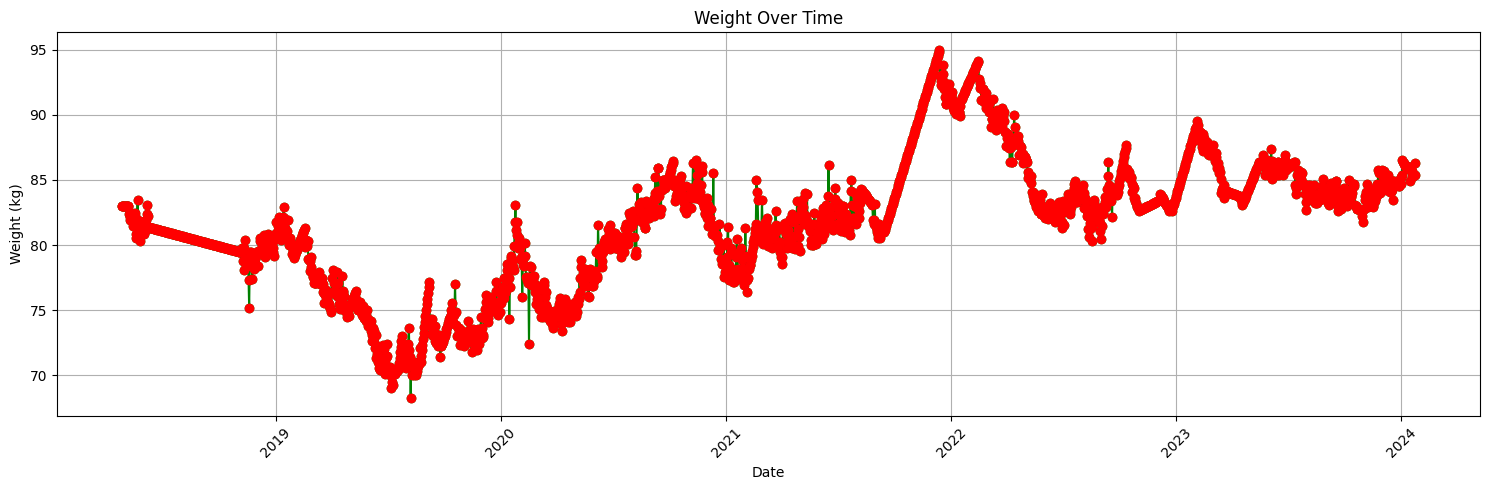

In [70]:
# plotting the dataframe to see if it is correct
plot_weight_over_time(df_final)

In [71]:
df_final.head()

,date,weight
0,2018-04-26,83.0
1,2018-04-27,83.0
2,2018-04-28,83.0
3,2018-04-29,83.0
4,2018-04-30,83.0


In [72]:
len(df_final)

2100

From the plot, it is pretty clear that all the issues has been fixed, and the data is already been cleaned up. Now I am ready to move on to the next stage.

## Create SQLite database

### Functions

In [73]:
# Function to create a database connection
def create_connection(db_file):
    """Create a database connection to a SQLite database."""
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        print("Connection established to database:", db_file)
    except Error as e:
        print(e)
    return conn

In [74]:
# Function to create a table
def create_table(conn, create_table_sql):
    """Create a table from the create_table_sql statement."""
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
        print("Table created successfully")
    except Error as e:
        print(e)

In [75]:
# Function to delete all records in my database when inserting
def delete_all_records(conn, table_name):
    """
    Delete all rows in the given table.
    """
    sql = f'DELETE FROM {table_name};'
    try:
        cur = conn.cursor()
        cur.execute(sql)
        conn.commit()
        print("All records deleted successfully")
    except Exception as e:
        print(f"An error occurred: {e}")

### Create SQLite database, table and insert data

In [76]:
# Create the database and the table
database = "my_weight_tracker.db"

sql_create_weight_records_table = """ CREATE TABLE IF NOT EXISTS weight_records (
                                        date text NOT NULL,
                                        weight real NOT NULL
                                    ); """

conn = create_connection(database)

if conn is not None:
    create_table(conn, sql_create_weight_records_table)
else:
    print("Error! cannot create the database connection.")

Connection established to database: my_weight_tracker.db
Table created successfully


In [77]:
# Delete all records in the database table
delete_all_records(conn, 'weight_records')

All records deleted successfully


In [78]:
# To make sure date column stays consistent when imported into database
df_final['date'] = pd.to_datetime(df_final['date']).dt.date
# Using pandas to import data into the sqlite database just created
df_final.to_sql('weight_records', conn, if_exists='append', index=False)

2100

In [79]:
# Verifing data insertion
pd.read_sql_query("SELECT * FROM weight_records", conn)


,date,weight
0,2018-04-26,83.000000
1,2018-04-27,83.000000
2,2018-04-28,83.000000
3,2018-04-29,83.000000
4,2018-04-30,83.000000
...,...,...
2095,2024-01-20,85.400101
2096,2024-01-21,85.299860
2097,2024-01-22,85.400101
2098,2024-01-23,86.300032


Now the database table looks good to go!
After investigations, SQLite does not support cloud services, I need to migrate my data into a cloud server database in order to make this application work.
I am going with PostgreSQL.

## PostgreSQL database, table, and inserting data

In [239]:
# Load the current environment variables
load_dotenv()
# Get credentials to connect
database_url = os.getenv('DATABASE_URL')
# Create the engine to connect to the PostgreSQL cloud database
engine = create_engine(database_url)

In [81]:
# Create the table and insert all my data to the database
df_final.to_sql('weight_records', engine, if_exists='replace', index=False)

100

In [82]:
# Verifing data insertion
pd.read_sql_query("SELECT * FROM weight_records", engine)

,date,weight
0,2018-04-26,83.000000
1,2018-04-27,83.000000
2,2018-04-28,83.000000
3,2018-04-29,83.000000
4,2018-04-30,83.000000
...,...,...
2095,2024-01-20,85.400101
2096,2024-01-21,85.299860
2097,2024-01-22,85.400101
2098,2024-01-23,86.300032


In [83]:
# Here is to test on the database and check queries
with engine.connect() as conn:
    query = text("SELECT * FROM weight_records ORDER BY date DESC LIMIT 1")
    result = conn.execute(query)
    
    # Fetch one result
    row = result.fetchone()
    
    # Print the result
    if row:
        print(row)
    else:
        print("No results found.")

(datetime.date(2024, 1, 24), 85.40007301)


In [87]:
# This part is to update weights if it gets messed up accidentally (by clicking or anything)
with engine.connect() as conn: 
    query = text("UPDATE weight_records SET weight = :weight WHERE date = :date")
    conn.execute(query, {'date': '2024-01-25', 'weight': 85})
    conn.commit() 

My first Cloud based SQL database is good to go!!!!!!!!! So excited!!!

Now, work is done here with jupyter notebook, time to move on to the .py file to create my dash application.

## Dash building
At this time point, I am moving on to the .py file and building my dashboard there.

## Modeling
Now I have finished building my dashboard, I want to further use machine learning tools to find underlying trends in my body weight data to further gain insights so that I can incorporate these into my dashboard.

In [89]:
# Prepare data for modeling
with engine.connect() as conn:
    query = "SELECT date, weight FROM weight_records ORDER BY date"
    data = pd.read_sql(query, conn)
data['date'] = pd.to_datetime(data['date'])
data.set_index('date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2102 entries, 2018-04-26 to 2024-01-26
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   weight  2102 non-null   float64
dtypes: float64(1)
memory usage: 32.8 KB


### Linear Regression

#### Feature engineering for Linear Regression

In [90]:
# Copy dataframe
df = data.copy()

# Day of the week as a categorical feature (0 = Monday, 6 = Sunday)
df['day_of_week'] = df.index.dayofweek

# Month as a categorical feature (1 = January, 12 = December)
df['month'] = df.index.month

# Season as a categorical feature based on meteorological seasons
# (1 = Winter, 2 = Spring, 3 = Summer, 4 = Fall)
df['season'] = df.index.month % 12 // 3 + 1

# You can also create a boolean feature for each season if you prefer
df['is_spring'] = df.index.month.isin([3, 4, 5])
df['is_summer'] = df.index.month.isin([6, 7, 8])
df['is_fall'] = df.index.month.isin([9, 10, 11])
df['is_winter'] = df.index.month.isin([12, 1, 2])
df['is_spring'] = df['is_spring'].astype(int)
df['is_summer'] = df['is_summer'].astype(int)
df['is_fall'] = df['is_fall'].astype(int)
df['is_winter'] = df['is_winter'].astype(int)

# One Hot Encode 
df = pd.get_dummies(df, columns=['day_of_week', 'month', 'season'], drop_first=True)

df.head()

,weight,is_spring,is_summer,is_fall,is_winter,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,month_6,month_7,month_8,month_9,month_10,month_11,month_12,season_2,season_3,season_4
date,,,,,,,,,,,,,,,,,,,,,
2018-04-26,83.0,1,0,0,0,False,False,True,False,False,...,False,False,False,False,False,False,False,True,False,False
2018-04-27,83.0,1,0,0,0,False,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
2018-04-28,83.0,1,0,0,0,False,False,False,False,True,...,False,False,False,False,False,False,False,True,False,False
2018-04-29,83.0,1,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2018-04-30,83.0,1,0,0,0,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


#### Run the Model

In [102]:
scaler = StandardScaler()
df['weight_scaled'] = scaler.fit_transform(df[['weight']])

In [105]:
# Define variables
X = df.drop(['weight', 'weight_scaled'], axis=1)
y = df['weight_scaled']

model = LinearRegression()
model.fit(X, y)

# Coefficients
coefficients = pd.DataFrame(model.coef_, X.columns, columns=['Coefficient'])
print("Coefficients:")
print(coefficients)

# Predictions
y_pred = model.predict(X)

# R^2 Score
r2 = r2_score(y, y_pred)
print("\nR^2 score (Coefficient of Determination):", r2)

# Mean Squared Error and Root Mean Squared Error
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)
print("Mean Squared Error:", mse)
print("Root Mean Squared Error:", rmse)

Coefficients:
                Coefficient
is_spring     -2.301582e+12
is_summer      2.992884e+12
is_fall        2.730997e+12
is_winter     -1.730836e+12
day_of_week_1 -3.447758e-02
day_of_week_2 -5.512493e-02
day_of_week_3 -4.736783e-02
day_of_week_4 -3.495490e-02
day_of_week_5 -3.517932e-02
day_of_week_6 -1.206427e-02
month_2        4.158212e-02
month_3        4.151321e+10
month_4        4.151321e+10
month_5        4.151321e+10
month_6       -7.180881e+12
month_7       -7.180881e+12
month_8       -7.180881e+12
month_9       -3.384965e+12
month_10      -3.384965e+12
month_11      -3.384965e+12
month_12      -1.351721e-01
season_2       5.292322e+11
season_3       2.457161e+12
season_4      -1.076868e+12

R^2 score (Coefficient of Determination): 0.046296471827644625
Mean Squared Error: 0.9537035281723556
Root Mean Squared Error: 0.9765774563097162


R2 is too small, which means weight is not being explained by features. I am going to try a different approach.

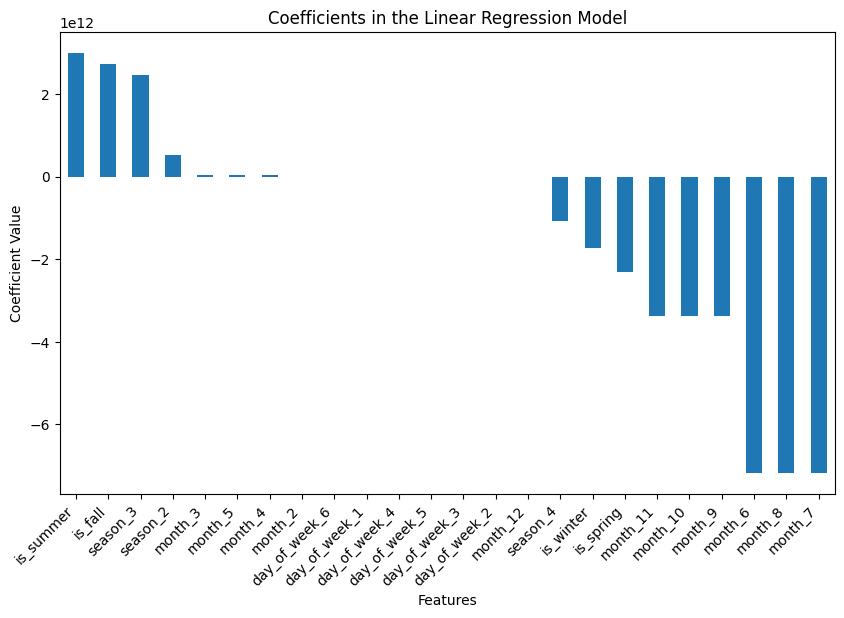

In [106]:
# Plot coefficients
# Sort the coefficients for better visualization
coefficients = coefficients.sort_values(by='Coefficient', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
coefficients['Coefficient'].plot(kind='bar')
plt.title('Coefficients in the Linear Regression Model')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.xticks(rotation=45, ha='right')  # Rotate feature names for better readability
plt.show()

### Prophet model
After doing some researches, the facebook prophet model seems to be the best suited for the goal of my project.
Since I want to find trends based on my body weight data, instead of predicting future weight values since I do not need them.

In [118]:
df_1 = data.copy()
df_1.reset_index()

,weight
date,
2018-04-26,83.000000
2018-04-27,83.000000
2018-04-28,83.000000
2018-04-29,83.000000
2018-04-30,83.000000
...,...
2024-01-22,85.400101
2024-01-23,86.300032
2024-01-24,85.400073


#### Initial Try

23:36:34 - cmdstanpy - INFO - Chain [1] start processing
23:36:35 - cmdstanpy - INFO - Chain [1] done processing
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightAppli

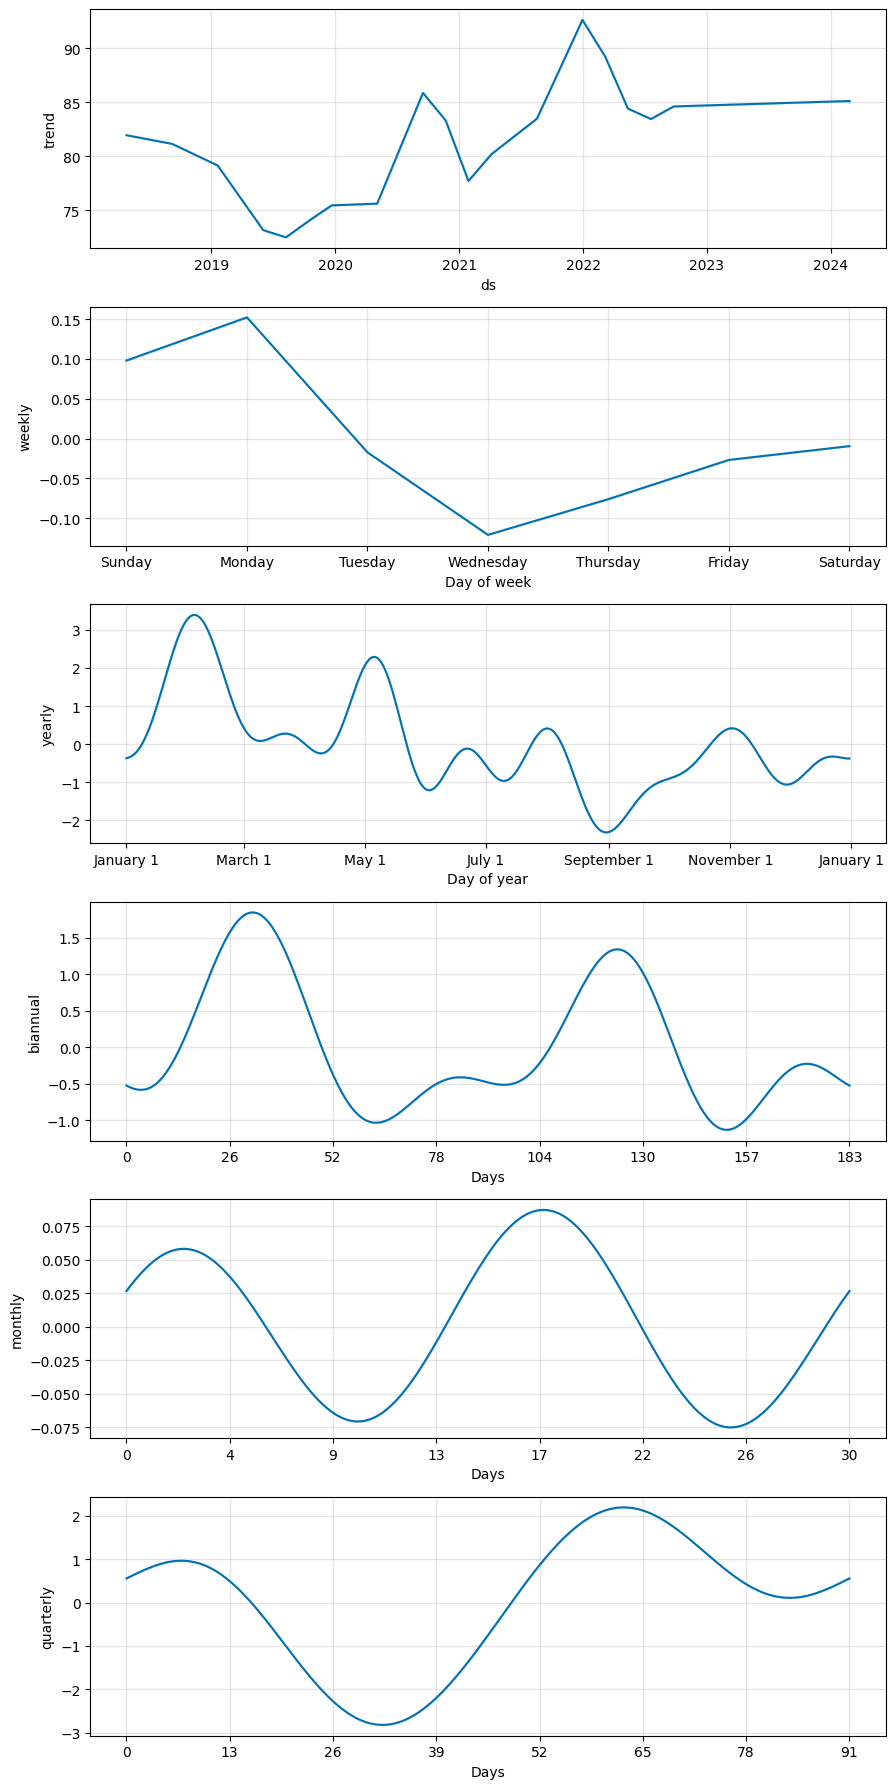

In [123]:
# Create a DataFrame with 'ds' and 'y' columns
df_prophet = df_1.reset_index().rename(columns={'date': 'ds', 'weight': 'y'})

# Initial model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=2)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
model.add_seasonality(name='biannual', period=365.25 / 2, fourier_order=5)

# fit the model

model.fit(df_prophet)

# Make future dataframe and predict (if necessary)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the components of the model
fig = model.plot_components(forecast)

This makes so much sense to me. This is exactly what I want from the machine learning tools: trends.

Now its time to make the model perfect for the application

#### Trying cross validation

In [125]:
# Now its time to make the model perfect for the application

# Perform cross-validation
# 'initial' is the training period, 'period' is the spacing between cutoff dates, 'horizon' is the prediction horizon
df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='180 days')


  0%|          | 0/7 [00:00<?, ?it/s]

23:43:06 - cmdstanpy - INFO - Chain [1] start processing
23:43:07 - cmdstanpy - INFO - Chain [1] done processing
23:43:07 - cmdstanpy - INFO - Chain [1] start processing
23:43:08 - cmdstanpy - INFO - Chain [1] done processing
23:43:08 - cmdstanpy - INFO - Chain [1] start processing
23:43:08 - cmdstanpy - INFO - Chain [1] done processing
23:43:08 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing
23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:09 - cmdstanpy - INFO - Chain [1] done processing
23:43:09 - cmdstanpy - INFO - Chain [1] start processing
23:43:10 - cmdstanpy - INFO - Chain [1] done processing
23:43:10 - cmdstanpy - INFO - Chain [1] start processing
23:43:11 - cmdstanpy - INFO - Chain [1] done processing


In [133]:
# Calculate performance metrics
df_p = performance_metrics(df_cv)
print(df_p.head(20))

   horizon        mse      rmse       mae      mape     mdape     smape  \
0  37 days  12.588797  3.548069  2.913173  0.034589  0.027546  0.034960   
1  38 days  13.116133  3.621620  2.984520  0.035445  0.027873  0.035827   
2  39 days  13.539562  3.679614  3.049426  0.036231  0.028396  0.036623   
3  40 days  14.114356  3.756908  3.128817  0.037187  0.029259  0.037596   
4  41 days  14.692579  3.833090  3.198685  0.038035  0.029521  0.038457   
5  42 days  15.244573  3.904430  3.263019  0.038816  0.030142  0.039254   
6  43 days  15.774994  3.971775  3.326780  0.039585  0.030551  0.040041   
7  44 days  16.271730  4.033823  3.383301  0.040265  0.031374  0.040744   
8  45 days  16.916130  4.112922  3.446652  0.041010  0.032047  0.041529   
9  46 days  17.485102  4.181519  3.503499  0.041692  0.032088  0.042238   
10 47 days  18.046582  4.248127  3.562291  0.042407  0.033789  0.042967   
11 48 days  18.626084  4.315795  3.617753  0.043075  0.034390  0.043658   
12 49 days  19.106623  4.

/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


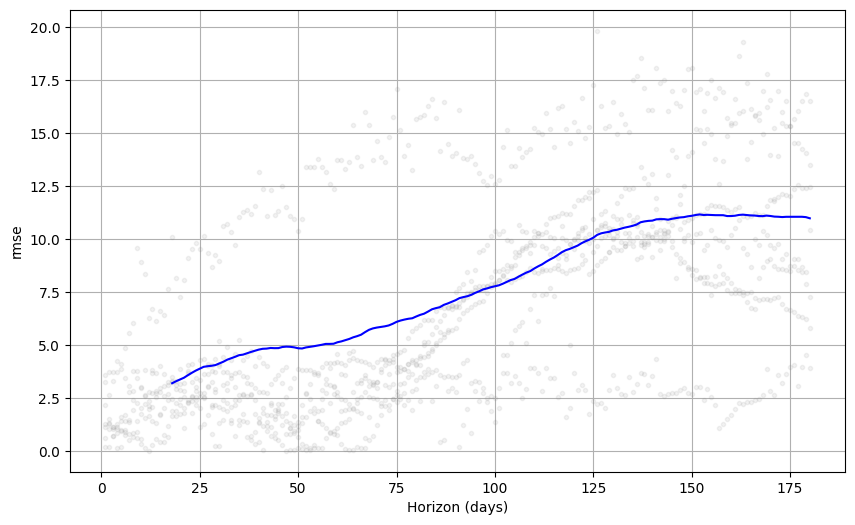

In [130]:
# Plot a performance metric, e.g., RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

#### Try grid search cross validation

In [132]:
# Grid Search Cross Validation
# Define the parameter grid
param_grid = {
    'changepoint_prior_scale': [0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
mae_scores = []  # Store the MAE scores for each set of parameters

# Use historical data for cross-validation
for params in all_params:
    model = Prophet(**params).fit(df_prophet)  # Fit model with given params
    df_cv = cross_validation(model, initial='730 days', period='180 days', horizon='365 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mae_scores.append(df_p['mae'].values[0])  # Store MAE

# Find the best parameters
best_params = all_params[np.argmin(mae_scores)]
print(best_params)

23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:20 - cmdstanpy - INFO - Chain [1] start processing
23:46:20 - cmdstanpy - INFO - Chain [1] done processing
23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing
23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:21 - cmdstanpy - INFO - Chain [1] done processing
23:46:21 - cmdstanpy - INFO - Chain [1] start processing
23:46:22 - cmdstanpy - INFO - Chain [1] done processing
23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:22 - cmdstanpy - INFO - Chain [1] done processing
23:46:22 - cmdstanpy - INFO - Chain [1] start processing
23:46:22 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:23 - cmdstanpy - INFO - Chain [1] done processing
23:46:23 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:24 - cmdstanpy - INFO - Chain [1] start processing
23:46:24 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:25 - cmdstanpy - INFO - Chain [1] start processing
23:46:25 - cmdstanpy - INFO - Chain [1] done processing
23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing
23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:26 - cmdstanpy - INFO - Chain [1] done processing
23:46:26 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:27 - cmdstanpy - INFO - Chain [1] done processing
23:46:27 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:28 - cmdstanpy - INFO - Chain [1] start processing
23:46:28 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:29 - cmdstanpy - INFO - Chain [1] start processing
23:46:29 - cmdstanpy - INFO - Chain [1] done processing
23:46:30 - cmdstanpy - INFO - Chain [1] start processing
23:46:31 - cmdstanpy - INFO - Chain [1] done processing
23:46:31 - cmdstanpy - INFO - Chain [1] start processing
23:46:32 - cmdstanpy - INFO - Chain [1] done processing
23:46:32 - cmdstanpy - INFO - Chain [1] start processing
23:46:33 - cmdstanpy - INFO - Chain [1] done processing
23:46:33 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing
23:46:34 - cmdstanpy - INFO - Chain [1] start processing
23:46:34 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:35 - cmdstanpy - INFO - Chain [1] done processing
23:46:35 - cmdstanpy - INFO - Chain [1] start processing
23:46:36 - cmdstanpy - INFO - Chain [1] done processing
23:46:36 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing
23:46:37 - cmdstanpy - INFO - Chain [1] start processing
23:46:37 - cmdstanpy - INFO - Chain [1] done processing
23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:38 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:38 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing
23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:39 - cmdstanpy - INFO - Chain [1] done processing
23:46:39 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing
23:46:40 - cmdstanpy - INFO - Chain [1] start processing
23:46:40 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:41 - cmdstanpy - INFO - Chain [1] done processing
23:46:41 - cmdstanpy - INFO - Chain [1] start processing
23:46:42 - cmdstanpy - INFO - Chain [1] done processing
23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:43 - cmdstanpy - INFO - Chain [1] done processing
23:46:43 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:44 - cmdstanpy - INFO - Chain [1] start processing
23:46:44 - cmdstanpy - INFO - Chain [1] done processing
23:46:45 - cmdstanpy - INFO - Chain [1] start processing
23:46:45 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:46 - cmdstanpy - INFO - Chain [1] done processing
23:46:46 - cmdstanpy - INFO - Chain [1] start processing
23:46:47 - cmdstanpy - INFO - Chain [1] done processing
23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:48 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:48 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:49 - cmdstanpy - INFO - Chain [1] done processing
23:46:49 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:50 - cmdstanpy - INFO - Chain [1] start processing
23:46:50 - cmdstanpy - INFO - Chain [1] done processing
23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:51 - cmdstanpy - INFO - Chain [1] done processing
23:46:51 - cmdstanpy - INFO - Chain [1] start processing
23:46:52 - cmdstanpy - INFO - Chain [1] done processing
23:46:52 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/6 [00:00<?, ?it/s]

23:46:53 - cmdstanpy - INFO - Chain [1] start processing
23:46:53 - cmdstanpy - INFO - Chain [1] done processing
23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing
23:46:54 - cmdstanpy - INFO - Chain [1] start processing
23:46:54 - cmdstanpy - INFO - Chain [1] done processing
23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:55 - cmdstanpy - INFO - Chain [1] done processing
23:46:55 - cmdstanpy - INFO - Chain [1] start processing
23:46:56 - cmdstanpy - INFO - Chain [1] done processing
23:46:56 - cmdstanpy - INFO - Chain [1] start processing
23:46:57 - cmdstanpy - INFO - Chain [1] done processing


{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


#### Now the real grid search cross validation

In [136]:
# Create a DataFrame with 'ds' and 'y' columns
df_prophet = df_1.reset_index().rename(columns={'date': 'ds', 'weight': 'y'})
df_prophet['cap'] = 95

In [139]:
# Define the parameter grid with more hyperparameters
param_grid = {
    'growth': ['logistic'],  # Trend growth model (Logistic because my weight has a maximum achievable point, it haven't gone over 90 kg for many years)
    'changepoints': [None],  # List of dates where potential changepoints will be included
    'n_changepoints': [50],  # Number of potential changepoints to include in the model
    'changepoint_range': [0.8],  # Proportion of history where changepoints are allowed
    'yearly_seasonality': [True],  # Yearly seasonality component (I know there is definitely yearly seasonality exists)
    'weekly_seasonality': [True],  # Weekly seasonality component (I know there is definitely weekly seasonality exists)
    'daily_seasonality': [False],  # Daily seasonality component
    'holidays': [None],  # DataFrame containing holiday dates
    'seasonality_mode': ['multiplicative'],  # Type of seasonality model
    'seasonality_prior_scale': [5.0],  # Strength of the seasonality model
    'holidays_prior_scale': [ 0.01],  # Strength of the holiday components model
    'changepoint_prior_scale': [0.01],  # Flexibility of the automatic changepoint selection
    'mcmc_samples': [0],  # Number of MCMC samples to draw (choosing 0 because I don't have enough computational power)
    'interval_width': [0.95],  # Width of the uncertainty intervals provided for the forecast
    'uncertainty_samples': [100]  # Number of simulated draws used to estimate uncertainty intervals
}
# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in product(*param_grid.values())]
rmse_scores = [] 

# Use historical data for cross-validation
for params in all_params:
    # Initialize a new Prophet model with the parameters from the grid
    model = Prophet(**params)
    # Add custom seasonalities
    model.add_seasonality(name='monthly', period=30.5, fourier_order=2)
    model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
    model.add_seasonality(name='biannual', period=365.25 / 2, fourier_order=5)
    # Fit the model with the parameters
    model.fit(df_prophet)
    
    # Perform cross-validation
    df_cv = cross_validation(model, initial='730 days', period='1 days', horizon='7 days') # Because I am more interested in the current state rather than long term, horizon is 7, and because I update weights daily, period is 1.
    
    # Calculate performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)
    
    # Append the MAE score for this parameter set to the list
    rmse_scores.append(df_p['rmse'].mean())  # Use mean RMSE across all cutoffs

# Find the best parameters based on the lowest RMSE
best_params_index = np.argmin(rmse_scores)
best_params = all_params[best_params_index]
best_rmse = rmse_scores[best_params_index]

print(f"Best Parameters: {best_params}")
print(f"Best RMSE: {best_rmse}")

00:30:28 - cmdstanpy - INFO - Chain [1] start processing
00:30:28 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1365 [00:00<?, ?it/s]

00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:30 - cmdstanpy - INFO - Chain [1] done processing
00:30:30 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1] done processing
00:30:31 - cmdstanpy - INFO - Chain [1] start processing
00:30:31 - cmdstanpy - INFO - Chain [1]

Best Parameters: {'growth': 'logistic', 'changepoints': None, 'n_changepoints': 50, 'changepoint_range': 0.8, 'yearly_seasonality': True, 'weekly_seasonality': True, 'daily_seasonality': False, 'holidays': None, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 5.0, 'holidays_prior_scale': 0.01, 'changepoint_prior_scale': 0.01, 'mcmc_samples': 0, 'interval_width': 0.95, 'uncertainty_samples': 100}
Best RMSE: 3.594590603965178


#### Since this is too computational expensive, I will just perform cross validation to get some insights


In [154]:
model = Prophet(**best_params)
# Add custom seasonalities
model.add_seasonality(name='monthly', period=30.5, fourier_order=2)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)
model.add_seasonality(name='biannual', period=365.25 / 2, fourier_order=5)
# fit the model
model.fit(df_prophet)
# Perform cross-validation
df_cv = cross_validation(model, initial='730 days', period='1 days', horizon='7 days')

00:55:26 - cmdstanpy - INFO - Chain [1] start processing
00:55:26 - cmdstanpy - INFO - Chain [1] done processing


  0%|          | 0/1365 [00:00<?, ?it/s]

00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:28 - cmdstanpy - INFO - Chain [1] start processing
00:55:28 - cmdstanpy - INFO - Chain [1] done processing
00:55:29 - cmdstanpy - INFO - Chain [1] start processing
00:55:29 - cmdstanpy - INFO - Chain [1] done processing
00:55:29 - cmdstanpy - INFO - Chain [1] start processing
00:55:29 - cmdstanpy - INFO - Chain [1] done processing
00:55:29 - cmdstanpy - INFO - Chain [1] start processing
00:55:29 - cmdstanpy - INFO - Chain [1]

/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:546: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt = df_none['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:547: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  x_plt_h = df_h['horizon'].astype('timedelta64[ns]').view(np.int64) / float(dt_conversions[i])


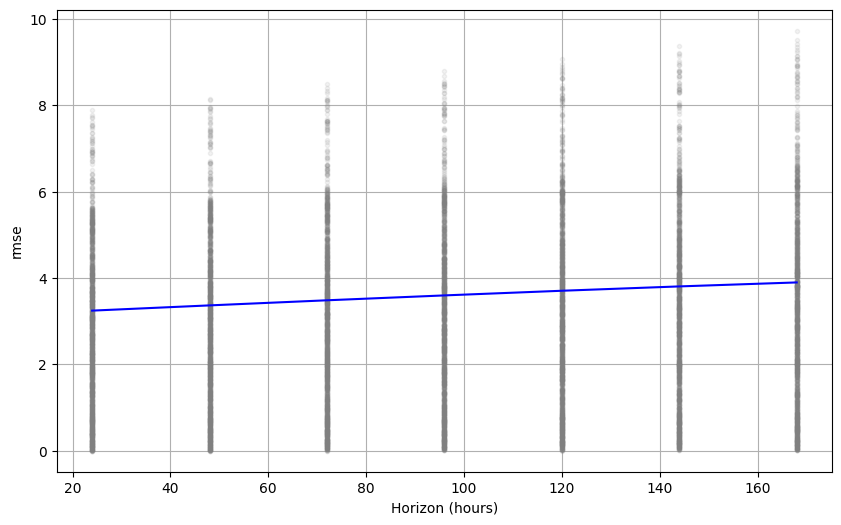

In [155]:
# Plot a performance metric, e.g., RMSE
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

#### After grid search Cross validation, now its time to train the real model

16:53:36 - cmdstanpy - INFO - Chain [1] start processing
16:53:37 - cmdstanpy - INFO - Chain [1] done processing
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightAppli

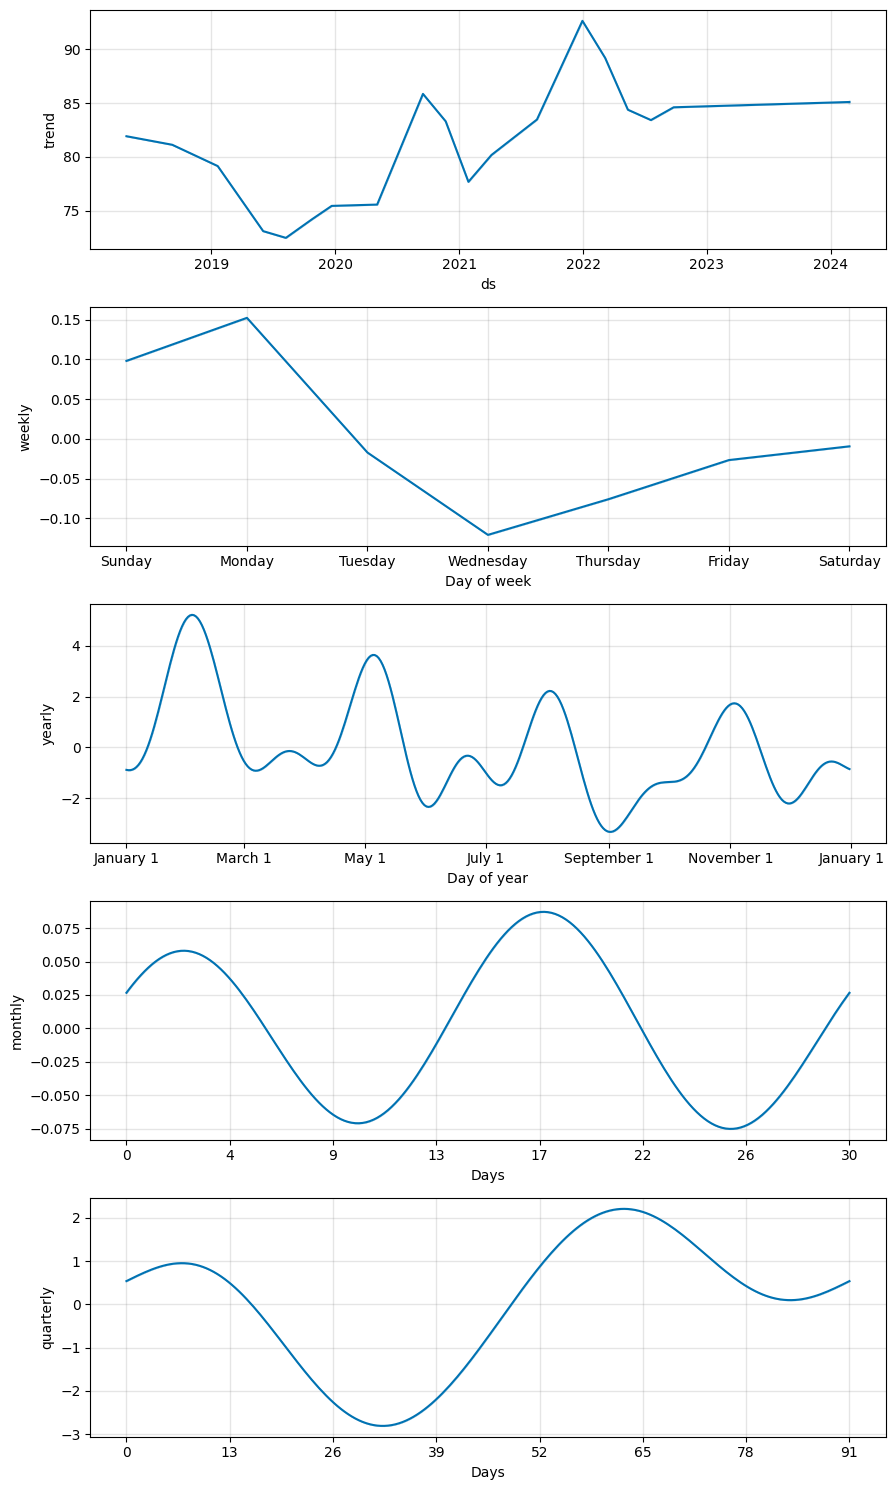

In [232]:
# Create a DataFrame with 'ds' and 'y' columns
df_prophet = df_1.reset_index().rename(columns={'date': 'ds', 'weight': 'y'})

# Initial model
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

# Add seasonality
model.add_seasonality(name='monthly', period=30.5, fourier_order=2)
model.add_seasonality(name='quarterly', period=91.25, fourier_order=3)

# fit the model
model.fit(df_prophet)

# Make future dataframe and predict (if necessary)
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

# Plot the components of the model
fig = model.plot_components(forecast)

In [158]:
# Save the model to a file
with open('best_prophet_model.pkl', 'wb') as f:
    pickle.dump(model, f)

/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
/Users/meizijie/Desktop/Portfolio/Projects/BodyWeightApplication/venv/lib/python3.11/site-packages/prophet/plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


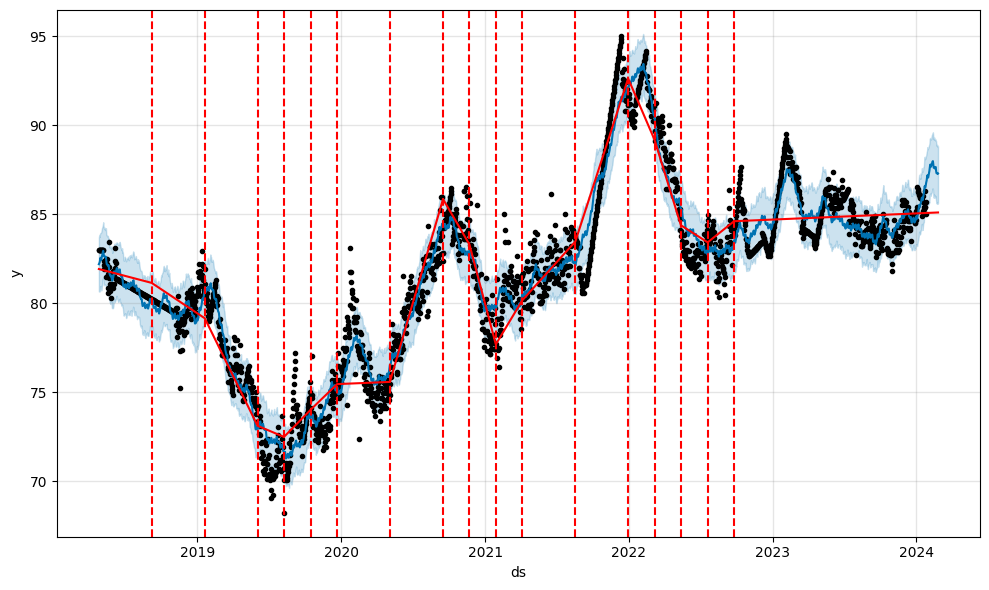

In [159]:
# You can also plot the changepoints to see where the model has detected significant changes in the trend
fig = model.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), model, forecast)
plt.show()

#### Finally save the trained model to my cloud based PostgreSQL database

In [162]:
# Create a table to store the model
with engine.connect() as conn:
    query = text('CREATE TABLE models (id SERIAL PRIMARY KEY, model_data BYTEA)')
    conn.execute(query)
    conn.commit()

In [ ]:
# add a training_date column to the table
with engine.connect() as conn:
    query = text("ALTER TABLE models ADD COLUMN training_date DATE")
    conn.execute(query)
    conn.commit()

In [222]:
# Connect to the database and delete all records from the models table (During Troubleshooting and Debuging)
try:
    with engine.connect() as conn:
        delete_query = text("DELETE FROM models")
        conn.execute(delete_query)
        conn.commit()
        print("All records deleted successfully.")
except Exception as e:
    print("Error during delete operation:", e)

All records deleted successfully.


In [233]:
training_date = datetime.now().date()
serialized_model = pickle.dumps(model)

# Insert the model into the database
try:
    with engine.connect() as conn:
        insert_query = text("""
            INSERT INTO models (model_data, training_date)
            VALUES (:model_data, :training_date)
        """)
        conn.execute(insert_query, {
            'model_data': serialized_model,
            'training_date': training_date
        })
        conn.commit()
        print("Data inserted successfully.")
except Exception as e:
    print("Error during insert operation:", e)

Data inserted successfully.


In [234]:
# Fetch the latest training date from the database
try:
    with engine.connect() as conn:
        fetch_query = text("""
            SELECT training_date FROM models
            WHERE training_date IS NOT NULL
            ORDER BY training_date DESC
            LIMIT 1
        """)
        result = conn.execute(fetch_query)
        latest_training_date = result.fetchone()
        if latest_training_date:
            print("The latest training date is:", latest_training_date[0])
        else:
            print("No training dates found in the database.")
except Exception as e:
    print("Error during fetch operation:", e)

The latest training date is: 2024-01-27


In [241]:
# Fetch all training dates from the database
try:
    with engine.connect() as conn:
        fetch_query = text("SELECT training_date FROM models")
        results = conn.execute(fetch_query).fetchall()
        if results:
            for idx, record in enumerate(results):
                print(f"Record {idx + 1}: Training date is {record[0]}")
        else:
            print("No records found in the database.")
except Exception as e:
    print("Error during fetch operation:", e)


Record 1: Training date is 2024-01-27
Record 2: Training date is 2024-01-27
Record 3: Training date is 2024-01-27
